<h1 style="font-family:Impact,Arial;font-size:50px">MWATS Filters Justifcaiton </h1>
<p> 


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import linregress

import matplotlib.pyplot as plt
%matplotlib inline

from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astropy import units as u
from astropy.coordinates import SkyCoord
import datetime

import warnings
warnings.simplefilter('ignore')

import time
import nmslib;
import os

import aplpy

In [9]:
def plot_lc_raw_data(source):
    all = data[data.source_id == source]
    all = all.sort_values(by='jd')
    plt.figure(figsize=(6, 4))
    f = list(all.raw_peak_flux)
    plt.plot(list(f), 'k.-', label='Flux', linewidth=0.5)
    plt.xlabel('Observation Number')
    plt.ylabel('Flux (Jy)')
    plt.savefig('thumbs/'+str(source)+'_basic_LC.jpg')

In [121]:
def get_basic_image(source_id):
    exists = os.path.isfile('thumbs/'+str(source_id)+'.jpg')
    if not exists:
        # Select random image
        plt.figure(figsize=[10,12])
        image = data[data.source_id == source_id].image.sample(1).values[0]
        d = data[data.source_id == source_id]
        grid = True
        size=(500, 500)
        dpi = 40
        figure = aplpy.FITSFigure('/Volumes/BEL27A-BKP01/MWATS/'+image, dimensions=[0,1], slices=[0,0], auto_refresh=False, dpi = dpi, figsize = (size[0] / float(dpi), size[1] / float(dpi)))
        ra = d.ra.mean()
        dec = d.dec.mean()
        circle_size = 0.5 # 1 degree circle
        figure.recenter(ra, dec, radius=0.75, width=1.0, height=1.0)
        #figure.recenter(ra, dec, circle_size) 
        if grid:
            try:
                figure.add_grid()
            except Exception as e:
                logging.warn("APLpy error adding grid to image: {0}".format(e))
        # Adjust the axis labels, otherwise they overlap
        # If the image is less than two arc minutes across, show seconds on the tick labels
    
        image_radius = circle_size
        if image_radius < 1.0 / 60.0 * 2:
                figure.tick_labels.set_xformat("hh:mm:ss")
                figure.tick_labels.set_yformat("dd:mm:ss")
        else:
                figure.tick_labels.set_xformat("hh:mm")
                figure.tick_labels.set_yformat("dd:mm")

        figure.tick_labels.set_xformat("dd:mm")
        figure.tick_labels.set_yformat("dd:mm")
        figure.axis_labels.set_font(size = 30.0)
        figure.tick_labels.set_font(size = 30.0)
        figure.show_grayscale(pmin=5.0, pmax=99.5, invert=False)
        figure.add_colorbar()
        figure.colorbar.set_axis_label_text('Jy / beam')
        figure.colorbar.set_font(size = 30.0)
        figure.colorbar.set_axis_label_font(size = 30.0)
        figure.save('thumbs/'+str(source_id)+'.jpg')
        figure.close()

In [2]:
def distance_from_median_pos(df):
    degrees_to_radians = np.pi/180.0
    phi1 = df.dec*degrees_to_radians
    phi2 = df.median_dec*degrees_to_radians

    theta1 = df.ra*degrees_to_radians
    theta2 = df.median_ra*degrees_to_radians
    
    cosine = (np.cos(phi1)*np.cos(phi2)*np.cos(theta1 - theta2) +
           np.sin(phi1)*np.sin(phi2))
    dist_from_centre = np.arccos(cosine)
    return (dist_from_centre/3.142)*180

## Loading the data
The input data file is the feather file created in Load.ipynb

In [4]:
time
data = pd.read_feather('mwats_raw_data_Mar_SQL.fth')

In [4]:
# Add in columns for median RA/DEC and flux.
tmp3 = data.groupby('source_id')[['ra','dec','raw_peak_flux']].median().reset_index() 
tmp3.columns = ['source_id', 'median_ra', 'median_dec', 'median_flux']
data = pd.merge(data,
                 tmp3[['source_id', 'median_ra', 'median_dec', 'median_flux']],
                 on='source_id')

In [5]:
filters = []
n_sources = data['source_id'].nunique() 
n_images  = data['image'].nunique()
n_fluxes  = data['raw_peak_flux'].count() 
filters.append([n_sources, n_images, n_fluxes, 'Unfiltered'])

In [6]:
# Add in columns for std RA/DEC and flux.
tmp4 = data.groupby('source_id')[['ra','dec']].std().reset_index() 
tmp4.columns = ['source_id', 'std_ra', 'std_dec']
data = pd.merge(data,
                 tmp4[['source_id', 'std_ra', 'std_dec']],
                 on='source_id')

In [41]:
# Add offet and flux_offset data columns. 
# offset = distance (in deg) from median position. 
# flux_offset = measured flux minus the median
data['offset'] = distance_from_median_pos(data)
data['flux_offset'] = np.sqrt((data.raw_peak_flux-data.median_flux)**2)

## Filtering: 
Below are the filters that have been applied to the data. These can be modified based on the users requirement. 

- _Distance from pointing centre_: We filter measurements less than 12 degrees from the pointing centre as per Bell et al. 2016, 2018. Before filtering we have 10 million flux measurements and after filtering 6.2 million. It is quite subjective to define the correct distance, but 12 degrees has worked well in the past.  

- _max__flux_: The brightest object to consider in the analysis. Objects > 50 Jy are typically so bright they cause problems (in imaging) and are hard to generate reliable light-curves. 

- _min__length_: The minimum nimber of points to consider in the light-curves. Objects with small numbers of measurements may be spurius and unrealiable.  



In [42]:
# Filters (some are applied later in the script)
max_dist   = 15.0 # Only use measurements less that 12-15 degrees from pointing centre of the image.
max_flux   = 50.0 # Jy. Only consider sources with a maximum flux of max_flux.
min_flux   = 0.25 # Jy. Only consider sources with a minimum flux of min_flux.
min_length = 35 # Minimum length of time-series to consider. 
max_rms    = 500 # Remove images with RMS greater than this. A few RFI soaked images crept threw. 
min_rms    = 25  # A couple of badly calibrated images need to be removed. 
max_offset = 0.0375 # beam = 3 pixels with width @ 0.75' per pixel (0.75*3)/60 = 0.0375
max_flux_offset = 5000 # flux_offset = |flux - median_flux| = Gets ride of small number of bad fits

## Apply distance from pointing centre filter:

In [43]:
data = data[data.distance < max_dist]

In [44]:
n_sources = data['source_id'].nunique() 
n_images  = data['image'].nunique()
n_fluxes  = data['raw_peak_flux'].count() 
filters.append([n_sources, n_images, n_fluxes, 'Distance from image centre filter'])

## Apply rms image filters:

In [45]:
data = data[data.rms < max_rms]

In [46]:
n_sources = data['source_id'].nunique() 
n_images  = data['image'].nunique()
n_fluxes  = data['raw_peak_flux'].count() 
filters.append([n_sources, n_images, n_fluxes, 'Max RMS filter'])

In [47]:
data = data[data.rms > min_rms]

In [48]:
n_sources = data['source_id'].nunique() 
n_images  = data['image'].nunique()
n_fluxes  = data['raw_peak_flux'].count() 
filters.append([n_sources, n_images, n_fluxes, 'Min RMS filter'])

## Apply position offset filter:

In [49]:
# Remove data points more than 3 pixels away from median position
data = data[data.offset < max_offset] # beam = 3 pixels with width @ 0.75' per pixel (0.75*3)/60 = 0.0375

In [50]:
n_sources = data['source_id'].nunique() 
n_images  = data['image'].nunique()
n_fluxes  = data['raw_peak_flux'].count() 
filters.append([n_sources, n_images, n_fluxes, 'Position offset filter'])

## Apply flux offset filter:

In [51]:
# Remove sources with really large flux offsets. They are just junk.
data = data[data.flux_offset<max_flux_offset]

## Remove sources that have more than one measurement in an image: 

In [53]:
good_sources = (data
                .groupby(['image_id','source_id'])
                .size().rename('count').to_frame()
                .reset_index().query('count == 2')['source_id']
               ).values
data = data[~data.source_id.isin(good_sources)]

In [20]:
n_sources = data['source_id'].nunique() 
n_images  = data['image'].nunique()
n_fluxes  = data['raw_peak_flux'].count() 
filters.append([n_sources, n_images, n_fluxes, 'Multiple measurements in same image filter'])

## House keeping

In [21]:
# Set the date as the index
data.set_index('time', inplace=True)

# Remove sources without as source_id
data = data[data.source_id.notnull()]

# Convert source_id to int
data['source_id'] = data.source_id.astype(int)

## Averaging the full dataset
The steps below re-sample the raw data on day timescales.  

### The cell below speeds up the computation of the averaged data.

In [22]:
%%time 

data_avg = (data.groupby(['source_id', pd.Grouper(freq = '1d')])
                .agg({
                        'raw_peak_flux': ['median', 'std'],
                        'jd': 'mean'
                     })
                .dropna()
           )

data_avg.columns = data_avg.columns.map('_'.join)

data_avg = (data_avg
                .rename(columns={
                    'raw_peak_flux_median': 'median_flux',
                    'raw_peak_flux_std': 'std_flux',
                    'jd_mean': 'mean_jd'
                                })
                .reset_index())


CPU times: user 26 s, sys: 18.8 s, total: 44.8 s
Wall time: 56.2 s


## Generate non-averaged statistics table

In [23]:
%%time

# Generate a new stats table with the mean flux of the non-averaging sources
stats = data.groupby('source_id')[['ra','dec','raw_peak_flux']].mean().reset_index() 
stats.columns = ['source_id', 'ra', 'dec', 'mean_raw_peak_flux']

# Add in the std
tmp = data.groupby('source_id')['raw_peak_flux'].std(ddof=1).reset_index()
tmp.columns = ['source_id', 'std_raw_peak_flux']
stats['std_raw_peak_flux'] = tmp['std_raw_peak_flux']

# Calculate the modulation index
stats['Mod'] = (stats.std_raw_peak_flux / stats.mean_raw_peak_flux) * 100 # In percent

# Add in a column with the number of measurements per source. 
tmp2 = data.groupby('source_id')['raw_peak_flux'].count().reset_index()
tmp2.columns = ['source_id', 'length']
stats['length'] = tmp2['length']

# Do some basic filtering of df to get rid of junky data points
stats = stats[(stats.mean_raw_peak_flux > 0) & (stats.std_raw_peak_flux > 0)]


CPU times: user 1.47 s, sys: 871 ms, total: 2.34 s
Wall time: 2.13 s


In [24]:
# Do some astronomy based filtering
stats = stats[(stats.mean_raw_peak_flux > min_flux)]
filtered_raw_data = data[data.source_id.isin(stats.source_id)]

n_sources = filtered_raw_data['source_id'].nunique() 
n_images  = filtered_raw_data['image'].nunique()
n_fluxes  = filtered_raw_data['raw_peak_flux'].count() 
filters.append([n_sources, n_images, n_fluxes, 'Remove min flux'])

stats = stats[(stats.mean_raw_peak_flux < max_flux)]
filtered_raw_data = data[data.source_id.isin(stats.source_id)]

n_sources = filtered_raw_data['source_id'].nunique() 
n_images  = filtered_raw_data['image'].nunique()
n_fluxes  = filtered_raw_data['raw_peak_flux'].count() 
filters.append([n_sources, n_images, n_fluxes, 'Remove max flux'])

stats = stats[(stats.length > min_length)]
filtered_raw_data = data[data.source_id.isin(stats.source_id)]

n_sources = filtered_raw_data['source_id'].nunique() 
n_images  = filtered_raw_data['image'].nunique()
n_fluxes  = filtered_raw_data['raw_peak_flux'].count() 
filters.append([n_sources, n_images, n_fluxes, 'Remove min length'])


 ##  Calculate the gradient (non-averaged)

In [25]:
%%time
# Get the dates and fluxes
dates  = filtered_raw_data.groupby('source_id')['jd'].apply(list)
fluxes = filtered_raw_data.groupby('source_id')['raw_peak_flux'].apply(list)

# Concat time and flux and do the fit
time_flux = pd.concat((dates, fluxes), axis=1)
grad_fit = time_flux.apply(lambda x: linregress(x['jd'], x['raw_peak_flux']), axis=1)

# Calculate all of the terms
grad = grad_fit.map(lambda x: x.slope)
fit_error = grad_fit.map(lambda x: x.stderr)
sig = grad_fit.map(lambda l: l.slope/l.stderr)
y_int = grad_fit.map(lambda x: x.intercept)

stats = stats.assign(sig=sig.values)
stats = stats.assign(grad=grad.values)
stats = stats.assign(fit_error=fit_error.values)
stats = stats.assign(y_int=y_int.values)

CPU times: user 47.7 s, sys: 2.68 s, total: 50.3 s
Wall time: 54.3 s


## Generate averaged statistics

In [26]:
# We want to work with the sources in our filtered stats table (i.e. have decent sized light-curves).
filtered_raw_avg_data = data_avg[data_avg.source_id.isin(stats.source_id)]

In [27]:
%%time
# Get the dates and fluxes
dates  = filtered_raw_avg_data.groupby('source_id')['mean_jd'].apply(list)
fluxes = filtered_raw_avg_data.groupby('source_id')['median_flux'].apply(list)

CPU times: user 15.6 s, sys: 1.11 s, total: 16.7 s
Wall time: 18.1 s


In [28]:
%%time
# Concat time and flux and do the fit
time_flux = pd.concat((dates, fluxes), axis=1)
grad_fit = time_flux.apply(lambda x: linregress(x['mean_jd'], x['median_flux']), axis=1)

CPU times: user 31.5 s, sys: 509 ms, total: 32 s
Wall time: 32.6 s


In [29]:
%%time
# Calculate all of the terms and add them to the stats table
avg_grad = grad_fit.map(lambda x: x.slope)
avg_fit_error = grad_fit.map(lambda x: x.stderr)
avg_sig = grad_fit.map(lambda l: l.slope/l.stderr)
avg_y_int = grad_fit.map(lambda x: x.intercept)

stats = stats.assign(avg_sig=avg_sig.values)
stats = stats.assign(avg_grad=avg_grad.values)
stats = stats.assign(avg_fit_error=avg_fit_error.values)
stats = stats.assign(avg_y_int=avg_y_int.values)

CPU times: user 208 ms, sys: 48 ms, total: 256 ms
Wall time: 224 ms


In [30]:
stats.set_index('source_id', inplace=True) # The indices of stats and tmp3 and tmp4 must be aligned. Let's set them to source_id

In [31]:
%%time
# Calculate the modulation index of the daily median flux measurements. 

# Add in the std of all the daily resampled measurements.
tmp3 = filtered_raw_avg_data.groupby('source_id')['median_flux'].std(ddof=1).reset_index()
tmp3.columns = ['source_id', 'avg_std']
tmp3.set_index('source_id', inplace=True)
stats['avg_std'] = tmp3['avg_std']

# Calculate the mean of the median daily flux measurements. 
tmp4 = filtered_raw_avg_data.groupby('source_id')['median_flux'].mean().reset_index()
tmp4.columns = ['source_id', 'avg_median']
tmp4.set_index('source_id', inplace=True)
stats['avg_median'] = tmp4['avg_median']

# Calculate the modulation index
stats['avg_Mod'] = (stats.avg_std / stats.avg_median) * 100 # In percent

CPU times: user 141 ms, sys: 32.3 ms, total: 174 ms
Wall time: 92.7 ms


In [32]:
stats.reset_index(inplace=True)
filtered_raw_avg_data.reset_index(inplace=True)
filtered_raw_data.reset_index(inplace=True)

# Nearest neighbours

Using https://github.com/nmslib/nmslib/blob/master/python_bindings/notebooks/search_vector_dense_optim.ipynb
with Euclidean distance.

In [33]:
source_positions = filtered_raw_data.groupby('source_id')[['ra', 'dec']].mean()
#source_positions = data.groupby('source_id')[['ra', 'dec']].mean()
source_positions.shape

(69400, 2)

In [34]:
source2idx = {s: i for i, s in enumerate(source_positions.index.values)}
idx2source = {v:k for (k, v) in source2idx.items()}
X = source_positions.values

In [35]:
# Set index parameters
# These are the most important ones
M = 15
efC = 100

num_threads = 4
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC, 'post' : 0}
print('Index-time parameters', index_time_params)

# Number of neighbors 
K=100

# Space name should correspond to the space name 
# used for brute-force search
space_name='l2'

# Intitialize the library, specify the space, the type of the vector and add data points 
index = nmslib.init(method='hnsw', space=space_name, data_type=nmslib.DataType.DENSE_VECTOR) 
index.addDataPointBatch(X)

# Create an index
start = time.time()
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC}
index.createIndex(index_time_params) 
end = time.time() 
print('Index-time parameters', index_time_params)
print('Indexing time = %f' % (end-start))

# Setting query-time parameters
efS = 100
query_time_params = {'efSearch': efS}
print('Setting query-time parameters', query_time_params)
index.setQueryTimeParams(query_time_params)

query_qty = X.shape[0]
start = time.time() 
nbrs = index.knnQueryBatch(X, k = K, num_threads = num_threads)
end = time.time() 
print('kNN time total=%f (sec), per query=%f (sec), per query adjusted for thread number=%f (sec)' % 
      (end-start, float(end-start)/query_qty, num_threads*float(end-start)/query_qty))

INFO:nmslib:M                   = 15
INFO:nmslib:indexThreadQty      = 4
INFO:nmslib:efConstruction      = 100
INFO:nmslib:maxM			          = 15
INFO:nmslib:maxM0			          = 30
INFO:nmslib:mult                = 0.369269
INFO:nmslib:skip_optimized_index= 0
INFO:nmslib:delaunay_type       = 2
INFO:nmslib:Set HNSW query-time parameters:
INFO:nmslib:ef(Search)         =20
INFO:nmslib:algoType           =2


Index-time parameters {'M': 15, 'indexThreadQty': 4, 'efConstruction': 100, 'post': 0}


INFO:nmslib:
The space is Euclidean
INFO:nmslib:Vector length=2
INFO:nmslib:Thus using function with any base
INFO:nmslib:searchMethod			  = 3
INFO:nmslib:Making optimized index
INFO:nmslib:Finished making optimized index
INFO:nmslib:Maximum level = 3
INFO:nmslib:Total memory allocated for optimized index+data: 10 Mb
INFO:nmslib:Set HNSW query-time parameters:
INFO:nmslib:ef(Search)         =100
INFO:nmslib:algoType           =2


Index-time parameters {'M': 15, 'indexThreadQty': 4, 'efConstruction': 100}
Indexing time = 2.031108
Setting query-time parameters {'efSearch': 100}
kNN time total=2.319657 (sec), per query=0.000033 (sec), per query adjusted for thread number=0.000134 (sec)


In [36]:
# Unpack the neighbours array into a dataframe

source_id = []
n_id1 = []
n_id2 = []
n_id3 = []
n_id4 = []
n_id5 = []

for n in nbrs:
    tmp_id = idx2source[n[0][0]]
    tmp_id1 = idx2source[n[0][1]]
    tmp_id2 = idx2source[n[0][2]]
    tmp_id3 = idx2source[n[0][3]]
    tmp_id4 = idx2source[n[0][4]]
    tmp_id5 = idx2source[n[0][5]]
    
    source_id.append(tmp_id)
    n_id1.append(tmp_id1)
    n_id2.append(tmp_id2)
    n_id3.append(tmp_id3)
    n_id4.append(tmp_id4)
    n_id5.append(tmp_id5)

In [37]:
neighbours = pd.DataFrame(
    {'source_id': source_id,
     'n_id1': n_id1,
     'n_id2': n_id2,
     'n_id3': n_id3,
     'n_id4': n_id4,
     'n_id5': n_id5,
     'source_id_ra'   : stats.set_index('source_id').loc[source_id].ra,
     'source_id_dec'  : stats.set_index('source_id').loc[source_id].dec,
      })

In [38]:
neighbours = neighbours.drop("source_id", axis=1)
neighbours = neighbours.reset_index()

In [39]:
n_id1_ra = stats.set_index('source_id').loc[n_id1].ra
n_id1_dec = stats.set_index('source_id').loc[n_id1].dec
n_id2_ra = stats.set_index('source_id').loc[n_id2].ra
n_id2_dec = stats.set_index('source_id').loc[n_id2].dec
n_id3_ra = stats.set_index('source_id').loc[n_id3].ra
n_id3_dec = stats.set_index('source_id').loc[n_id3].dec
n_id4_ra = stats.set_index('source_id').loc[n_id4].ra
n_id4_dec = stats.set_index('source_id').loc[n_id4].dec
n_id5_ra = stats.set_index('source_id').loc[n_id5].ra
n_id5_dec = stats.set_index('source_id').loc[n_id5].dec

neighbours = neighbours.assign(n_id1_ra=n_id1_ra.values)
neighbours = neighbours.assign(n_id1_dec=n_id1_dec.values)
neighbours = neighbours.assign(n_id2_ra=n_id2_ra.values)
neighbours = neighbours.assign(n_id2_dec=n_id2_dec.values)
neighbours = neighbours.assign(n_id3_ra=n_id3_ra.values)
neighbours = neighbours.assign(n_id3_dec=n_id3_dec.values)
neighbours = neighbours.assign(n_id4_ra=n_id4_ra.values)
neighbours = neighbours.assign(n_id4_dec=n_id4_dec.values)
neighbours = neighbours.assign(n_id5_ra=n_id5_ra.values)
neighbours = neighbours.assign(n_id5_dec=n_id5_dec.values)

In [40]:
def vectorized_distance_on_unit_sphere(s1_ra, s2_ra, s1_dec, s2_dec):
    degrees_to_radians = np.pi/180.0
    phi1 = s1_dec*degrees_to_radians
    phi2 = s2_dec*degrees_to_radians

    theta1 = s1_ra*degrees_to_radians
    theta2 = s2_ra*degrees_to_radians
    
    cosine = (np.cos(phi1)*np.cos(phi2)*np.cos(theta1 - theta2) +
           np.sin(phi1)*np.sin(phi2))
    dist_from_centre = np.arccos(cosine)
    return (dist_from_centre/3.142)*180

In [41]:
neighbours['dist_1'] = vectorized_distance_on_unit_sphere(neighbours.source_id_ra, neighbours.n_id1_ra, neighbours.source_id_dec, neighbours.n_id1_dec)
neighbours['dist_2'] = vectorized_distance_on_unit_sphere(neighbours.source_id_ra, neighbours.n_id2_ra, neighbours.source_id_dec, neighbours.n_id2_dec)
neighbours['dist_3'] = vectorized_distance_on_unit_sphere(neighbours.source_id_ra, neighbours.n_id3_ra, neighbours.source_id_dec, neighbours.n_id3_dec)
neighbours['dist_4'] = vectorized_distance_on_unit_sphere(neighbours.source_id_ra, neighbours.n_id4_ra, neighbours.source_id_dec, neighbours.n_id4_dec)
neighbours['dist_5'] = vectorized_distance_on_unit_sphere(neighbours.source_id_ra, neighbours.n_id5_ra, neighbours.source_id_dec, neighbours.n_id5_dec)

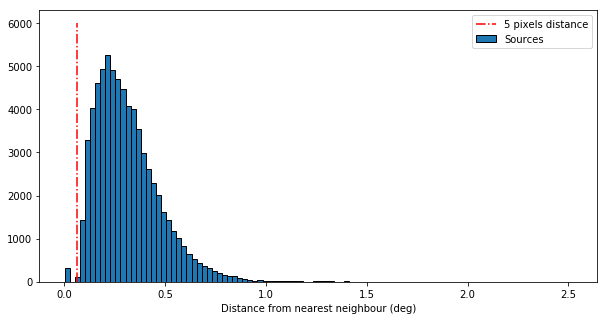

In [42]:
#ax=np.log10(neighbours.dist_0).hist(bins=100, figsize=(10, 5), grid=False, ec='k')
ax=(neighbours.dist_1).hist(bins=100, figsize=(10, 5), grid=False, ec='k', label='Sources')
plt.plot([0.0625,0.0625],[0,6000], 'r-.', label='5 pixels distance')
plt.xlabel('Distance from nearest neighbour (deg)')
plt.legend()

## Filter out sources that are closer than x pixels

In [43]:
# Filter out the nearby sources
pixel_distance = 5.0
close_source = neighbours[neighbours.dist_1 > (0.0125*pixel_distance)] # > 5 pixels ADD AS PARAMETER ABOVE
stats = stats[stats.source_id.isin(close_source.source_id)] # Do stats table only, leave in place in data tables. 

In [84]:
filtered_raw_data = data[data.source_id.isin(stats.source_id)]
n_sources = filtered_raw_data['source_id'].nunique() 
n_images  = filtered_raw_data['image'].nunique()
n_fluxes  = filtered_raw_data['raw_peak_flux'].count() 
filters.append([n_sources, n_images, n_fluxes, 'Nearby source filter'])

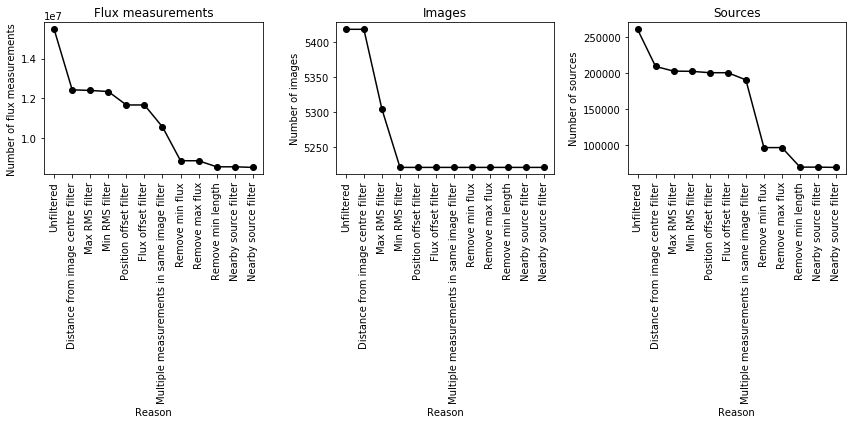

In [85]:
import matplotlib.ticker as ticker
fs = []
ims = []
ss = []
reason = []
reason.append('dummy')
for i in range(len(filters)):
    ss.append(filters[i][0])
    ims.append(filters[i][1])
    fs.append(filters[i][2])
    reason.append(filters[i][3])
    
plt.figure(figsize=[12,6])

axes = plt.subplot(1,3,1)
plt.plot(fs, 'ko-')
plt.ylabel('Number of flux measurements')
plt.xlabel('Reason')
a=axes.get_xticks().tolist()
a=reason
axes.set_xticklabels(a)
plt.xticks(rotation=90)
axes.locator_params(axis='x', nbins=20)
plt.title('Flux measurements')

axes = plt.subplot(1,3,2)
plt.plot(ims, 'ko-')
plt.ylabel('Number of images')
plt.xlabel('Reason')
a=axes.get_xticks().tolist()
a=reason
axes.set_xticklabels(a)
plt.xticks(rotation=90)
axes.locator_params(axis='x', nbins=20)
plt.title('Images')

axes = plt.subplot(1,3,3)
plt.plot(ss, 'ko-')
plt.ylabel('Number of sources')
plt.xlabel('Reason')
a=axes.get_xticks().tolist()
a=reason
axes.set_xticklabels(a)
plt.xticks(rotation=90)
axes.locator_params(axis='x', nbins=20)
plt.title('Sources')
plt.tight_layout()
plt.savefig('figures/QC.eps')


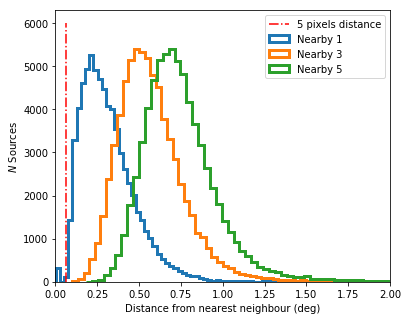

In [83]:
ax=(neighbours.dist_1).hist(bins=100, figsize=(6, 5), grid=False, histtype='step', linewidth=3, label='Nearby 1')
#ax=(neighbours.dist_2).hist(bins=80, figsize=(10, 5), grid=False, histtype='step', linewidth=3, label='Sources')
ax=(neighbours.dist_3).hist(bins=100, figsize=(6, 5), grid=False, histtype='step', linewidth=3, label='Nearby 3')
#ax=(neighbours.dist_4).hist(bins=90, figsize=(10, 5), grid=False, histtype='step',linewidth=3, label='Sources')
ax=(neighbours.dist_5).hist(bins=100, figsize=(6, 5), grid=False, histtype='step',linewidth=3, label='Nearby 5')
plt.plot([0.0625,0.0625],[0,6000], 'r-.', label='5 pixels distance')
plt.xlabel('Distance from nearest neighbour (deg)')
#plt.xscale('log')
plt.legend()
plt.xlim(0.0,2.0)
plt.ylabel('$N$ Sources')
plt.tight_layout
plt.savefig('figures/nearby.eps')

In [68]:
fs[6]-fs[7]

1693585

In [69]:
ss[6] - ss[7]

94180

In [86]:
filters

[[261046, 5418, 15463503, 'Unfiltered'],
 [209386, 5418, 12431617, 'Distance from image centre filter'],
 [202920, 5304, 12401500, 'Max RMS filter'],
 [202596, 5221, 12345217, 'Min RMS filter'],
 [200693, 5221, 11673486, 'Position offset filter'],
 [200677, 5221, 11673469, 'Flux offset filter'],
 [190738, 5221, 10572961, 'Multiple measurements in same image filter'],
 [96558, 5221, 8879376, 'Remove min flux'],
 [96552, 5221, 8878666, 'Remove max flux'],
 [69400, 5221, 8575261, 'Remove min length'],
 [69400, 5221, 8575261, 'Nearby source filter'],
 [69027, 5221, 8545699, 'Nearby source filter']]

## Add a column for source density 

In [39]:
#stats.set_index('source_id', inplace=True)
#box_size = 0.25 
#stats['s_density'] = stats.apply(lambda s: data[data.ra.between(s.ra-box_size, s.ra+box_size) & 
                                                data.dec.between(s.dec-box_size, s.dec+box_size)]['source_id'].nunique(), axis=1)

### Save the data

In [38]:
stats.reset_index(inplace=True)
filtered_raw_avg_data.reset_index(inplace=True)
filtered_raw_data.reset_index(inplace=True)
neighbours.reset_index()

,index,source_id,n_id1,n_id2,n_id3,n_id4,n_id5,source_id_ra,source_id_dec,n_id1_ra,...,n_id3_dec,n_id4_ra,n_id4_dec,n_id5_ra,n_id5_dec,dist_1,dist_2,dist_3,dist_4,dist_5
0,0,3045,3140,3400,3302,3645,3288,22.932674,-70.002974,22.637308,...,-69.603542,22.477568,-69.099182,21.900402,-69.626978,0.180695,0.553926,0.473901,0.917546,0.517842
1,1,3054,3245,3184,3580,3367,3089,29.589072,-69.987369,29.118648,...,-69.207544,28.211346,-69.510528,31.236225,-69.928143,0.332296,0.428277,0.866557,0.674264,0.567508
2,2,3070,3213,3723,4106,3897,3691,352.690179,-69.952318,352.484479,...,-68.391322,351.669304,-68.675636,351.079305,-69.014292,0.219503,1.053691,1.570152,1.326419,1.094603
3,3,3081,3521,3740,3965,4183,4605,11.677428,-69.953863,11.225793,...,-68.569749,12.215364,-68.281141,11.093081,-67.774091,0.703099,1.028363,1.396887,1.683441,2.189622
4,4,3083,3220,3358,3136,3634,3974,20.446343,-69.950554,20.689724,...,-69.862155,21.114927,-69.110302,20.061765,-68.559943,0.231345,0.423317,0.314067,0.872050,1.397079
5,5,3089,3184,3663,3580,3839,3930,31.236225,-69.928143,30.683771,...,-69.207544,30.979662,-68.782196,31.965769,-68.630361,0.239238,0.863806,0.746749,1.149359,1.323007
6,6,3090,3424,3690,3706,4314,3136,17.608897,-69.915916,17.792461,...,-68.979819,18.231539,-68.082484,19.569002,-69.862155,0.494719,0.924642,1.037959,1.846697,0.675985
7,7,3091,3340,3110,3529,3701,3861,95.752976,-69.919880,96.007823,...,-69.273867,96.371277,-69.001247,95.727482,-68.740840,0.373286,0.306027,0.694977,0.943765,1.178921
8,8,3092,3862,4123,3903,3175,3847,90.402186,-69.925399,90.598827,...,-68.655155,88.133168,-69.796089,88.415279,-68.773917,1.187984,1.608487,1.383297,0.791709,1.347600
9,9,3099,3457,3135,4113,4041,4371,60.703652,-69.920189,59.917590,...,-68.388933,59.428396,-68.479946,59.960984,-68.012829,0.609038,0.354125,1.577545,1.509483,1.925608


In [39]:
stats.to_feather('stats_table.fth')
filtered_raw_avg_data.to_feather('avg_data.fth')
filtered_raw_data.to_feather('data.fth')
neighbours.to_feather('neighbours.fth')

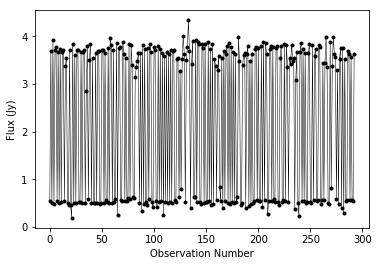

In [10]:
plot_lc_raw_data(128821.0)

In [122]:
get_basic_image(128821.0)

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.372e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.108e+00 [aplpy.core]


<Figure size 720x864 with 0 Axes>